In [1]:
import torch
import numpy as np 
import pandas as pd
from statistics import fmean
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
import random

le = LabelEncoder()
rng = np.random.default_rng()
file_path = "/media/lars/F77E-7D07/"

In [13]:
unique_pairs = pd.read_csv(file_path + "unique_pairs.csv")

In [14]:
unique_pairs.sort_values("common_ratio", ascending=False)

,app_id_1,title_1,app_id_2,title_2,common_positive,common_recommended,pmi,app_1_recommended,app_2_recommended,common_ratio
113532,284750,Enigmatis: The Ghosts of Maple Creek,284770,Enigmatis 2: The Mists of Ravenwood,118.0,134.0,-1.553610,87.0,86.0,0.436482
2174720,225300,Tomb Raider II,225320,Tomb Raider III,136.0,173.0,-1.559414,164.0,68.0,0.427160
3176416,538680,The Legend of Heroes: Trails of Cold Steel,748490,The Legend of Heroes: Trails of Cold Steel II,232.0,247.0,-1.421049,279.0,61.0,0.420784
1215539,224980,Tomb Raider IV: The Last Revelation,225320,Tomb Raider III,97.0,124.0,-1.628906,63.0,117.0,0.407895
855884,1105510,Yakuza 5 Remastered,1388590,Yakuza 6: The Song of Life,460.0,483.0,-1.609728,392.0,316.0,0.405542
...,...,...,...,...,...,...,...,...,...,...
2753703,287980,Mini Metro,527440,Rustangelo,0.0,0.0,-inf,1310.0,136.0,0.000000
159037,654220,Flash Point: Fire Rescue,1088770,Car Mechanic Simulator VR,0.0,0.0,-inf,27.0,44.0,0.000000
159039,654220,Flash Point: Fire Rescue,1475810,Ghostwire: Tokyo,0.0,0.0,-inf,27.0,1549.0,0.000000
159041,654220,Flash Point: Fire Rescue,897410,Esports Life Tycoon,0.0,0.0,-inf,27.0,30.0,0.000000


In [15]:
unique_pairs = unique_pairs[(unique_pairs["common_recommended"] >= 10)]

In [16]:
len(unique_pairs)

844736

In [22]:
unique_pairs.sort_values("pmi").head()

,app_id_1,title_1,app_id_2,title_2,common_positive,common_recommended,pmi,app_1_recommended,app_2_recommended,common_ratio,label
3497830,933110,Age of Empires III: Definitive Edition,1665460,eFootball™ 2024,0.0,19.0,-inf,2018.0,1104.0,0.006049,False
3469797,895400,Deadside,1147660,ArcheAge: Unchained,0.0,14.0,-inf,1883.0,525.0,0.005780,False
562729,268130,Heat Signature,393420,Hurtworld,0.0,11.0,-inf,1814.0,1285.0,0.003537,False
2628720,236110,Dungeon Defenders II,2208920,Assassin's Creed Valhalla,0.0,10.0,-inf,2267.0,848.0,0.003200,False
2389167,24010,Train Simulator Classic,39690,ArcaniA,0.0,10.0,-inf,1098.0,338.0,0.006916,False


In [23]:
unique_pairs["label"] = unique_pairs["pmi"] >= -10

In [24]:
(unique_pairs["label"] >=0.5).value_counts()

label
False    766001
True      78735
Name: count, dtype: int64

In [25]:
#unique_pairs = unique_pairs[unique_pairs["common_recommended"] + unique_pairs["app_1_recommended"] + unique_pairs["app_2_recommended"] >= 100]

In [26]:
unique_pairs = unique_pairs.reset_index(drop=True)

In [27]:
games = pd.concat([
    unique_pairs[['app_id_1', 'title_1']].rename(columns={'app_id_1': 'app_id', 'title_1': 'title'}),
    unique_pairs[['app_id_2', 'title_2']].rename(columns={'app_id_2': 'app_id', 'title_2': 'title'})
])

# Drop duplicates to get unique games
games = games.drop_duplicates().reset_index(drop=True)

games


,app_id,title
0,13500,Prince of Persia: Warrior Within™
1,113020,Monaco: What's Yours Is Mine
2,226560,Escape Dead Island
3,250180,METAL SLUG 3
4,253980,Enclave
...,...,...
2663,1303950,Toodee and Topdee
2664,1200330,Strategic Mind: Blitzkrieg
2665,1846460,Burnhouse Lane
2666,1707870,RiffTrax: The Game


In [28]:
unique_pairs = unique_pairs.drop(["title_1", "title_2"],axis=1)

In [29]:
games_1 = pd.DataFrame(le.fit_transform(unique_pairs["app_id_1"]))
games_2 = pd.DataFrame(le.fit_transform(unique_pairs["app_id_2"]))
labels = unique_pairs["label"]

In [30]:
games.to_csv(file_path + "games_network.csv", index=False)
unique_pairs.to_csv(file_path + "unique_pairs_network.csv", index=False)
games_1.to_csv(file_path + "games_1.csv", index=False)
games_2.to_csv(file_path + "games_2.csv", index=False)
labels.to_csv(file_path + "labels.csv", index=False)

In [31]:
# Define the neural network with an embedding layer
class SiameseNN(nn.Module):
    def __init__(self, num_embeddings):
        super(SiameseNN, self).__init__()
        
        self.embedding = nn.Embedding(num_embeddings, 64)
    
    def forward_one(self, x):
        x = self.embedding(x)
        x = x.view(x.size(0), -1)  # Flatten the embedding output
        output = x
        return output
    
    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2
    
    def get_distance(self, input1, input2):
        return F.pairwise_distance(input1, input2, keepdim=True)
    
    def get_embedding(self, x):
        return self.forward_one(x)
    
    

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    
    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2)+
                                      (1-label) * torch.pow(torch.clamp((self.margin - euclidean_distance), min=0.0), 2))
        return loss_contrastive




In [32]:
games_1 = pd.read_csv(file_path + "games_1.csv")
games_2 = pd.read_csv(file_path + "games_2.csv")
labels = pd.read_csv(file_path + "labels.csv")
games = pd.read_csv(file_path + "games_network.csv")
unique_pairs = pd.read_csv(file_path + "unique_pairs_network.csv")

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Read all data and send to GPU
games_1_tensor = torch.tensor(games_1.values, dtype=torch.long).to(device)
games_2_tensor = torch.tensor(games_2.values, dtype=torch.long).to(device)
labels_tensor = torch.tensor(labels.values, dtype=torch.float32).view(-1, 1).to(device)
games_le = pd.DataFrame(le.fit_transform(games["app_id"]))
games_le_tensor = torch.tensor(games_le.values, dtype=torch.long).to(device)

# Initialize the network, loss function and optimizer
num_embeddings = len(games_le)
model = SiameseNN(num_embeddings).to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

""" # Load the saved state dictionary
state_dict = torch.load("siamese_nn.pth")

# Apply the state dictionary to the model
model.load_state_dict(state_dict) """

Using device: cuda


' # Load the saved state dictionary\nstate_dict = torch.load("siamese_nn.pth")\n\n# Apply the state dictionary to the model\nmodel.load_state_dict(state_dict) '

In [33]:
len(unique_pairs[unique_pairs["label"] == True]) / len(unique_pairs[unique_pairs["label"] == False])

0.10278707207954037

In [35]:
import time

total_time = 10 * 60
print_time = 60
gpu_size = 1024000

recommendations = unique_pairs["common_ratio"]
#recommendations = unique_pairs["common_recommended"] + unique_pairs["app_1_recommended"] + unique_pairs["app_2_recommended"]
positive = unique_pairs["label"]
negative = (1 - unique_pairs["label"])

start_time = time.time()
print_start = time.time()
num_epochs = 0
losses = 0
last_loss = 1
length = len(unique_pairs)

while time.time() - start_time < total_time:

    """distances = model.get_distance(games_1_tensor, games_2_tensor).cpu().detach().numpy().reshape(length)

    if num_epochs % 10 == 0:
        sample_weights = np.max(2-distances,0) ** 2 * negative
    else:
        sample_weights = distances ** 2 * positive """

    sample_weights = recommendations
    sample_weights /= sample_weights.sum()
    sampled_indices = np.random.choice(unique_pairs.index, size=gpu_size, p=sample_weights)

    sampled_games_1 = games_1_tensor[sampled_indices]
    sampled_games_2 = games_2_tensor[sampled_indices]
    sampled_labels = labels_tensor[sampled_indices]

    optimizer.zero_grad()
    output_1, output_2 = model(sampled_games_1, sampled_games_2)
    loss = criterion(output_1, output_2, sampled_labels)
    loss.backward()
    optimizer.step()
    
    losses += loss.item()

    if print_time < (time.time() - print_start):
        print(f'Time elapsed: {int((time.time() - print_start))}s, {num_epochs} epochs, Percentage lost: {((last_loss - (losses / num_epochs)) / last_loss) * 100:.8f}, Loss: {losses / num_epochs:.8f}')

        last_loss = losses / num_epochs
        losses = 0
        print_start = time.time()
        torch.save(model.state_dict(), "siamese_nn.pth")
        num_epochs = 0

    num_epochs += 1

torch.save(model.state_dict(), "siamese_nn.pth")

Time elapsed: 60s, 112 epochs, Percentage lost: 88.30849904, Loss: 0.11691501
Time elapsed: 60s, 111 epochs, Percentage lost: 1.05760349, Loss: 0.11567851
Time elapsed: 61s, 105 epochs, Percentage lost: 0.02845857, Loss: 0.11564559
Time elapsed: 61s, 78 epochs, Percentage lost: 0.03925498, Loss: 0.11560020
Time elapsed: 60s, 71 epochs, Percentage lost: 0.00117002, Loss: 0.11559884
Time elapsed: 60s, 64 epochs, Percentage lost: 0.02228830, Loss: 0.11557308
Time elapsed: 60s, 66 epochs, Percentage lost: 0.00252931, Loss: 0.11557015
Time elapsed: 60s, 63 epochs, Percentage lost: -0.00541293, Loss: 0.11557641
Time elapsed: 60s, 61 epochs, Percentage lost: -0.02053126, Loss: 0.11560014


In [41]:
torch.save(model.state_dict(), "siamese_nn.pth")

In [37]:
model.eval()

with torch.no_grad():
    embeddings = model.get_embedding(games_le_tensor)

model.train()

games["location"] = list(embeddings.cpu().detach().numpy())
locations_array = np.array(games["location"].tolist())


In [38]:
# Reduce the dimensionality of the embeddings to 2D
tsne = TSNE(n_components=2, random_state=0, n_jobs=-10)
games["location_2d"] = list(tsne.fit_transform(locations_array))

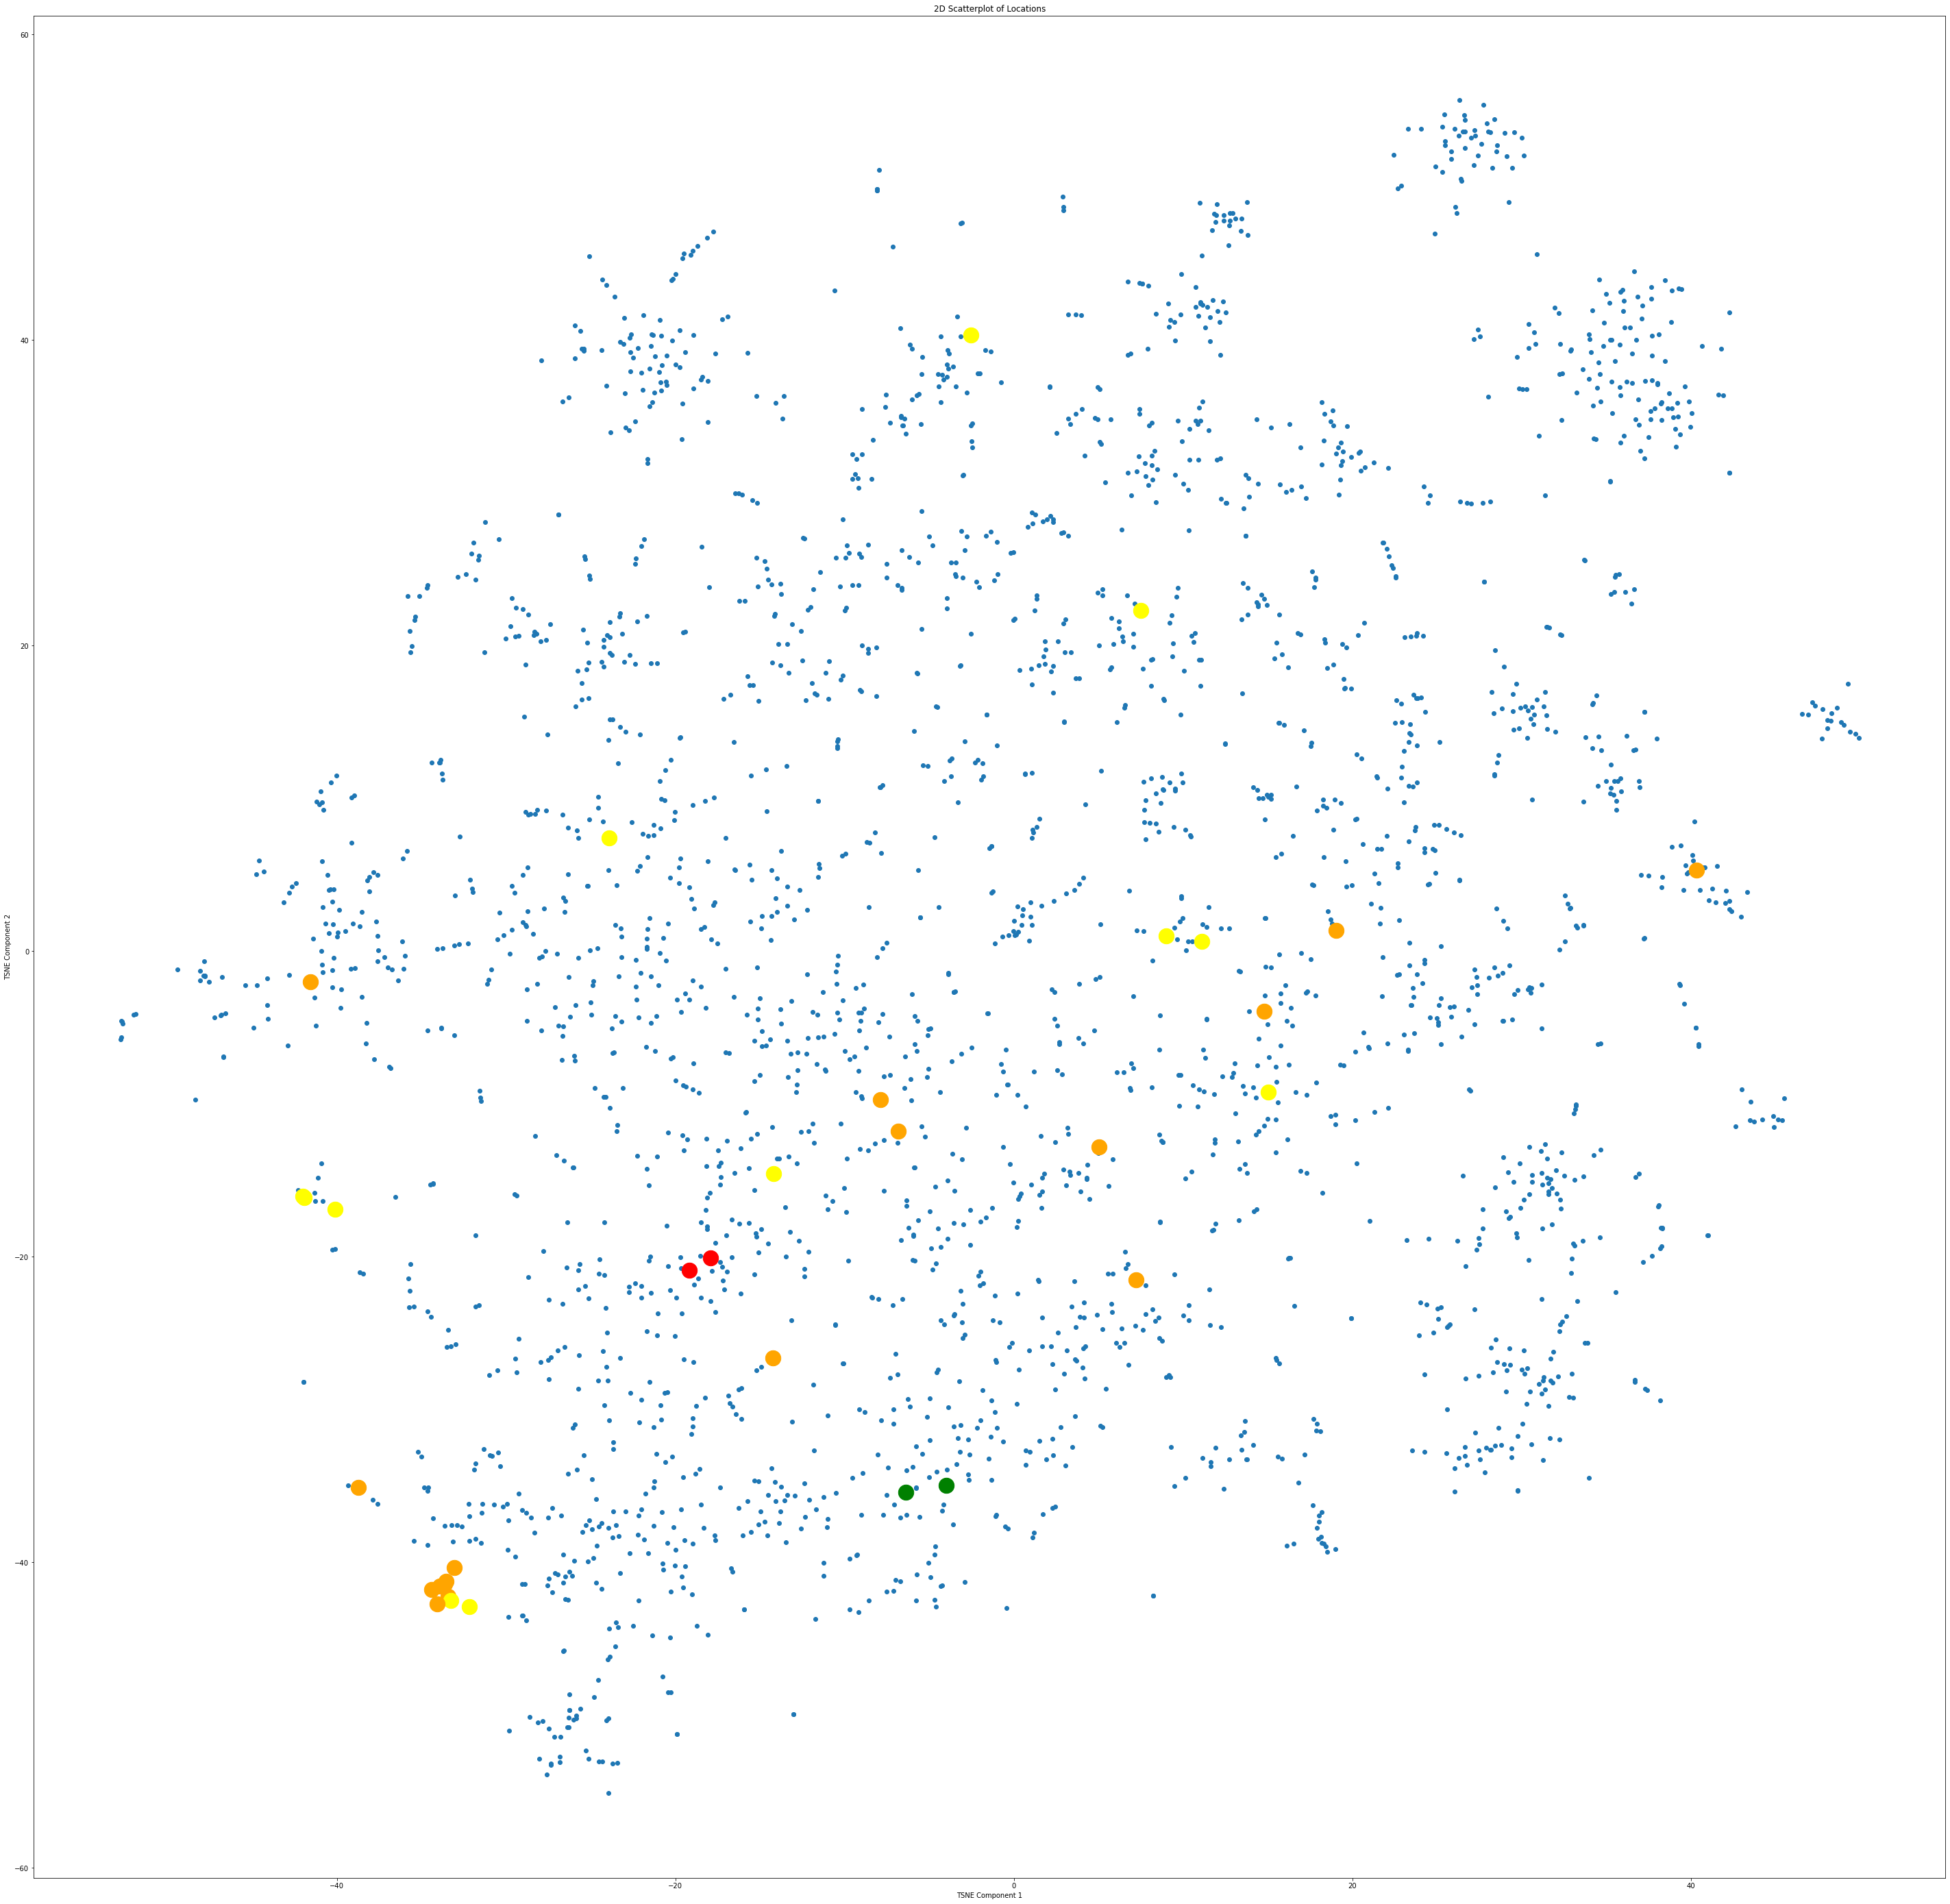

In [40]:
plt.figure(figsize=(50, 50))
plt.scatter(games["location_2d"].apply(lambda x: x[0]), games["location_2d"].apply(lambda x: x[1]))

""" for i, row in games.iterrows():
    plt.text(row["location_2d"][0], row["location_2d"][1], str(row["title"]), fontsize=9) """


for i, row in games.iterrows():
    if str(row["title"]) == "Portal":
        x, y = row["location_2d"][0], row["location_2d"][1]
        plt.scatter(x, y, color='red', s=500)  # Larger and red dot
    if str(row["title"]) == "Portal 2":
        x, y = row["location_2d"][0], row["location_2d"][1]
        plt.scatter(x, y, color='red', s=500)  # Larger and red dot
    if str(row["title"]) == "Metro 2033 Redux":
        x, y = row["location_2d"][0], row["location_2d"][1]
        plt.scatter(x, y, color='green', s=500)  # Larger and green dot
    if str(row["title"]) == "Metro: Last Light Redux":
        x, y = row["location_2d"][0], row["location_2d"][1]
        plt.scatter(x, y, color='green', s=500)  # Larger and green dot
    if str(row["title"]) in list(games[games["title"].str.startswith("LEGO", na=False)]["title"]):
        x, y = row["location_2d"][0], row["location_2d"][1]
        plt.scatter(x, y, color='yellow', s=500)  # Larger and yellow dot
    if str(row["title"]) in list(games[games["title"].str.startswith("STAR WARS", na=False)]["title"]):
        x, y = row["location_2d"][0], row["location_2d"][1]
        plt.scatter(x, y, color='orange', s=500)  # Larger and orange dot



plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.title("2D Scatterplot of Locations")
plt.show()

In [44]:
games.to_csv("filtered_archive/games_locations.csv")